In [4]:
import pandas as pd
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Stores in Spain:
# https://www.kammi.it/store-locator/negozio_131.html
# https://www.kammi.it/store-locator/negozio_88.html
# https://www.kammi.it/store-locator/negozio_89.html
# https://www.kammi.it/store-locator/negozio_90.html

# stores in Switzerland
# https://www.kammi.it/store-locator/negozio_108.html
# https://www.kammi.it/store-locator/negozio_107.html
# https://www.kammi.it/store-locator/negozio_109.html
# https://www.kammi.it/store-locator/negozio_110.html

# stores in Belgium
# https://www.kammi.it/store-locator/negozio_70.html

# Store pages have a number in (0, 200) as identifier in the URL
not_italian_stores = [131, 88, 89, 90, 108, 107, 109, 110, 70]
limit = 200
base_url = f"https://www.kammi.it/store-locator/negozio_"
html = ".html"

################################################# N O T E S #####################################################
#                    There are stores not in Italy, they're handled with not_italian_stores                     #
#             Store pages follow the structure "https://www.kammi.it/store-locator/negozio_{number}.html"       #
#                  where number is in a range of (1, 200), where not each number has a store                    #
#            Store pages only contain province letters, need to convert them we need a conversion table         #
#                       Conversion table: https://www.studiomadera.it/vari/195-province                         #
#                Conversion table has a dirty entry for Rome, should be "RM" instead of "Roma"                  #
#    For the map: https://medium.com/@ardito.bryan/creating-a-covid-19-map-of-italy-using-python-1f3182c1fd88   #
#################################################################################################################

In [5]:
l_stores_province_letters = []
# Loop 1 to limit to get all the stores
for n in range(1, limit):
    # Skip stores outside of Italy
    if n in not_italian_stores:
        continue
    
    url = f"{base_url}{n}{html}"
    response = requests.get(url)
    bs = BeautifulSoup(response.content, "html.parser")
    stringa = bs.find("h1", class_ = "text-center h5 fw-bold").text
    test = len(stringa) # Pages with h1 "Negozio: " don't have infos, they're empty
    if test > 9:        # Length of "Negozio: " is 9, so when > 9 there are infos
        provincia = pd.read_html(url)[0].loc[3,1]
        l_stores_province_letters.append(provincia)


In [6]:
# A dataframe to store a conversion table from province's two letters to region name
df_province_to_region = pd.read_html("https://www.studiomadera.it/vari/195-province")[0]

# Cleaning: use first row as header
new_header = df_province_to_region.iloc[0]
df_province_to_region = df_province_to_region[1:]
df_province_to_region.columns = new_header
df_province_to_region = df_province_to_region.set_index("SIGLA")
df_province_to_region


,PROVINCIA,REGIONE
SIGLA,,
AG,Agrigento,Sicilia
AL,Alessandria,Piemonte
AN,Ancona,Marche
AO,Aosta,Valle d'Aosta
AQ,L'Aquila,Abruzzo
...,...,...
VC,Vercelli,Piemonte
VR,Verona,Veneto
VV,Vibo-Valentia,Calabria


In [7]:
# Dirty data, should be RM instead of Roma
df_province_to_region.rename(index={'Roma':'RM'}, inplace = True)

In [8]:
# Initialize dictionary with (Region name, 0) to count the number of stores in each region
tuples = [(key, 0) for key in df_province_to_region["REGIONE"].unique().tolist()]
dict_stores_per_region = dict(tuples)

for province_letters in l_stores_province_letters:
    region = df_province_to_region["REGIONE"].loc[province_letters] # get region from the table using 
    dict_stores_per_region[region] += 1 # Increment count of number stores in that region

<AxesSubplot: title={'center': '\nNumero di negozi per regione\n'}>

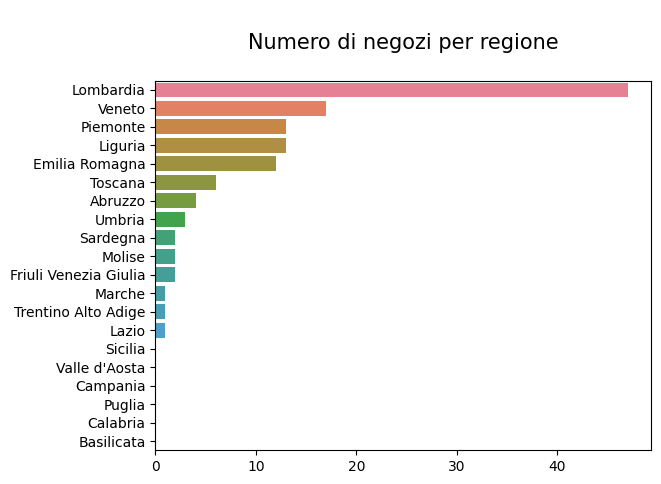

In [9]:
# Sorting by number of stores, which is by dict_stores_per_region.values()
dict_stores_per_region = dict(sorted(dict_stores_per_region.items(), key=lambda item: item[1], reverse = True))
labels = dict_stores_per_region.keys()
fig, ax = plt.subplots()
plt.title("\nNumero di negozi per regione\n", size = 15)

sns.barplot(x = dict_stores_per_region.values(), y = labels, hue = labels)

<AxesSubplot: title={'center': '\nNumero di negozi per regione\n'}>

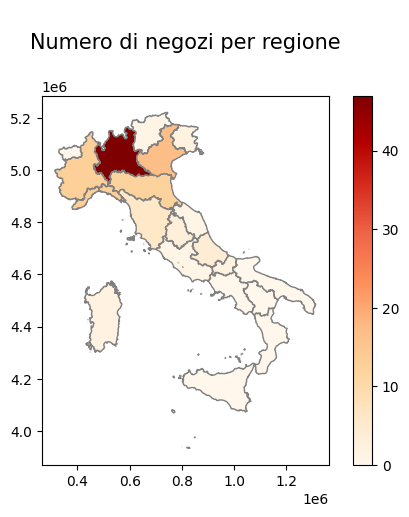

In [10]:
path_to_italy_map = os.path.join(os.getcwd(), "italy-map", "reg2011_g.shp")
italy = gpd.read_file(path_to_italy_map)
italy = italy.sort_values("NOME_REG")
regions = dict(sorted(dict_stores_per_region.items(), key=lambda item: item[0]))
# Replacing region names column with ours because they're written differently
italy = italy.drop("NOME_REG", axis = 1)
italy["NOME_REG"] = regions.keys()

# Add stores count per region as new column "NEGOZI"
italy["NEGOZI"] = regions.values()

fig, ax = plt.subplots()
plt.title("\nNumero di negozi per regione\n", size = 15)

italy.plot(
ax = ax,
edgecolor = 'grey',
column = "NEGOZI",
cmap = "OrRd",
legend = True)